# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install monai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 25.9 MB/s eta 0:00:00


In [ ]:
!mkdir /content/dataset/
!unzip /content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C.zip -d /content/dataset/train3C/
!unzip /content/drive/MyDrive/MaiaSpain/CAD/project/dataset/val3C.zip -d /content/dataset/val3C/
!mkdir -p /content/dataset/test3C/
!tar -xvzf /content/drive/MyDrive/MaiaSpain/CAD/project/dataset/test/test_3c.tgz -C /content/dataset/test3C/

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/bcc/bcc00664.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/bcc/bcc01784.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/bcc/bcc01938.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/bcc/bcc00105.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/bcc/bcc00919.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/bcc/bcc01817.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train/bcc/bcc01318.jpg  
  inflating: /content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/datase

# Initialization

In [ ]:
%cd /content/drive/MyDrive/MaiaSpain/CAD/project/

/content/drive/.shortcut-targets-by-id/1fTsBspXCDEVY7q8PyaNkRq-51xfzOyIV/MaiaSpain/CAD/project


In [ ]:
import os
import numpy as np
from torch.utils.data import WeightedRandomSampler
from monai.transforms import (
    Compose, Rand2DElasticd, RandRotate90d, RandFlipd, RandAffined, ScaleIntensityd,
    RandCoarseShuffled, EnsureTyped, LoadImaged, Resized, ToTensord, NormalizeIntensityd
)
from monai.data import PersistentDataset, Dataset, DataLoader
from monai.losses import FocalLoss
from PIL import Image
import torch
from torch import nn, tensor
from torch.optim import Adam
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, StepLR
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, cohen_kappa_score
from tqdm import tqdm
from torchvision import models
from shutil import rmtree
from transformers import DeiTForImageClassification, DeiTConfig
import csv

# Dataloader

In [ ]:
cls_to_idx = {'mel':0, 'bcc':1, 'scc':2}
idx_to_cls = {0:'mel', 1:'bcc', 2:'scc'}

def get_weights(data_path):
  classes = os.listdir(data_path)
  num_samples = {cls: len(os.listdir(os.path.join(data_path, cls))) for cls in classes}
  weights = {cls: (1 / num_samples[cls]) / sum((1 / v for v in num_samples.values())) for cls in classes}
  return weights

def get_data(data_path, cls_weights):
  data = []
  sample_weights = []
  classes = os.listdir(data_path)
  for cls in classes:
      cls_path = os.path.join(data_path, cls)
      for image_name in os.listdir(cls_path):
          image_path = os.path.join(cls_path, image_name)
          data.append({'image':image_path, 'label':cls_to_idx[cls]})
          sample_weights.append(cls_weights[cls])
  return data, sample_weights

In [ ]:
base_transforms = [
    LoadImaged('image',ensure_channel_first=True),
    Resized('image',(224, 224)),
    NormalizeIntensityd('image')
]

augmentations = [
    ScaleIntensityd('image',0,1),
    Rand2DElasticd('image',prob=0.5, spacing=56, magnitude_range=(1, 3), padding_mode="zeros"),
    RandRotate90d('image',prob=0.5, spatial_axes=[0, 1]),
    RandFlipd('image',prob=0.5, spatial_axis=0),
    RandFlipd('image',prob=0.5, spatial_axis=1),
    RandAffined('image',prob=0.5,rotate_range=(0.5, 0.5),padding_mode="zeros",),
    NormalizeIntensityd('image')
]

train_transform = Compose(base_transforms + augmentations)
val_transform = Compose(base_transforms)

# rmtree('/content/cache/',True)

cls_weights = get_weights("/content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train")
train_data, train_weights = get_data("/content/dataset/train3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/train3C/train", cls_weights)
val_data, val_weights = get_data("/content/dataset/val3C/content/drive/MyDrive/MaiaSpain/CAD/project/dataset/val3C/val", cls_weights)

train_dataset = PersistentDataset(data=train_data, transform=train_transform, cache_dir='/content/cache/train')
train_sampler = WeightedRandomSampler(train_weights, len(train_weights))
train_loader = DataLoader(train_dataset, batch_size=32, sampler=train_sampler, num_workers=os.cpu_count(), pin_memory=True)
val_dataset = PersistentDataset(data=val_data, transform=val_transform, cache_dir='/content/cache/val')
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)

# Visualization

/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-p

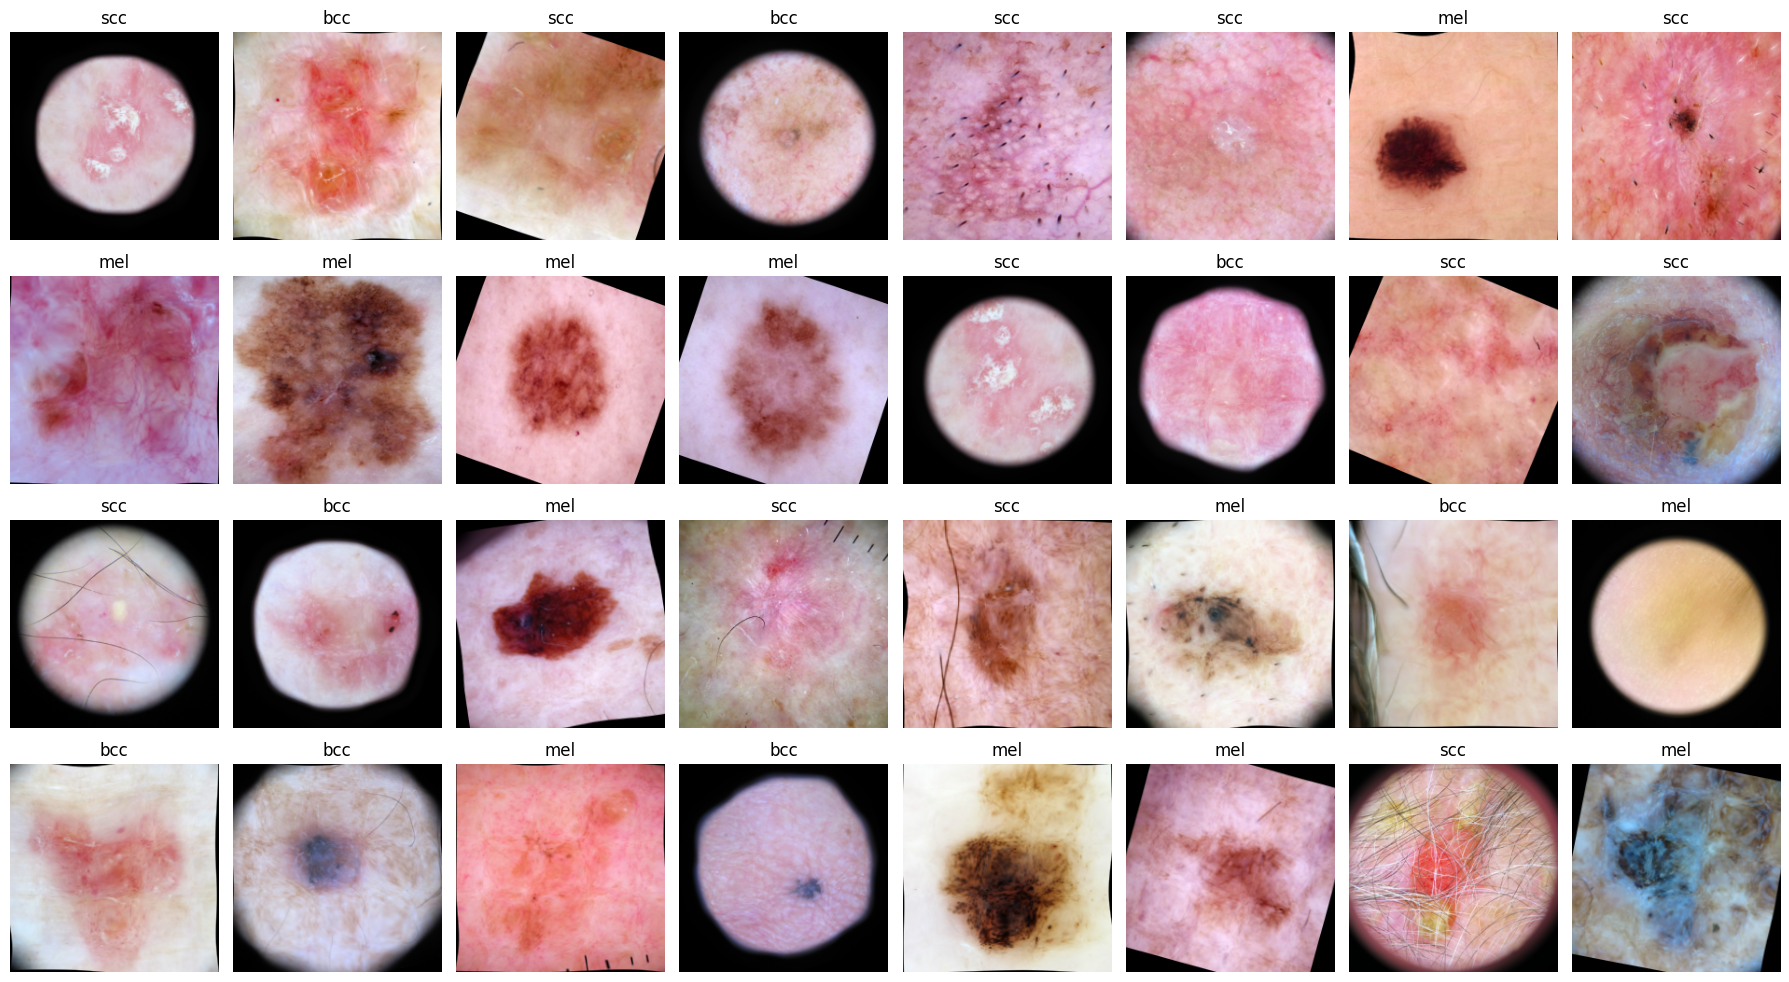

In [ ]:
# import matplotlib.pyplot as plt

# train_loader.dataset.transform.transforms = train_loader.dataset.transform.transforms+(ScaleIntensityd('image',0,1),)
# plt.figure(figsize=(18,10))
# batch = next(iter(train_loader))
# for i in range(32):
#   image, label = batch['image'][i], batch['label'][i]
#   plt.subplot(4,8,i+1)
#   plt.imshow(image.permute(1,2,0).numpy())
#   plt.title(idx_to_cls[label.item()])
#   plt.axis('off')
# plt.tight_layout()
# plt.show()

# Training and Evaluation

In [ ]:
def calculate_metrics(labels, preds):
    accuracy = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="macro")
    recall = recall_score(labels, preds, average="macro")
    f1 = f1_score(labels, preds, average="macro")
    kappa = cohen_kappa_score(labels, preds)
    return accuracy, precision, recall, f1, kappa

def train_and_evaluate_model(model, train_loader, val_loader, device, epochs=30, min_delta=0.0001):
    model = model.to(device)
    criterion = FocalLoss(to_onehot_y=True, use_softmax=True)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4)
    scheduler=StepLR(optimizer, step_size=15, gamma=0.2)
    best_kappa = 0
    save_dir = "models_alberb_3cls/"
    os.makedirs(save_dir, exist_ok=True)

    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs}"):
            images, labels = batch['image'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(images)
            outputs, embedding = outputs.logits, outputs.hidden_states[-1][:, -1, :]
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        scheduler.step()

        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_loss / len(train_loader):.4f}")

        model.eval()
        all_preds, all_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                images, labels = batch['image'].to(device), batch['label'].to(device)
                outputs = model(images)
                outputs = outputs.logits
                preds = torch.argmax(outputs, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        accuracy, precision, recall, f1, kappa = calculate_metrics(all_labels, all_preds)
        cm = confusion_matrix(all_labels, all_preds)
        print(f"Validation Metrics - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}, Kappa: {kappa:.4f}")
        print(f"Confusion Matrix:\n{cm}")

        if kappa > best_kappa + min_delta:
            model_path = os.path.join(save_dir, f"best_model_{kappa:.4f}.pth")
            torch.save(model.state_dict(), model_path)
            if os.path.exists(os.path.join(save_dir, f"best_model_{best_kappa:.4f}.pth")):
              os.remove(os.path.join(save_dir, f"best_model_{best_kappa:.4f}.pth"))
            best_kappa = kappa
            print(f"Model saved to {model_path}")

# Experiments

In [ ]:
from transformers import DeiTForImageClassification, DeiTConfig

config = DeiTConfig.from_pretrained("facebook/deit-base-distilled-patch16-224")
config.num_labels, config.output_hidden_states = 3, True
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", config=config)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/69.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/349M [00:00<?, ?B/s]

Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
train_and_evaluate_model(
    model, train_loader, val_loader, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"), epochs=100
)

Epoch 1/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 1/100, Training Loss: 0.0849


Validation Metrics - Accuracy: 0.7961, Precision: 0.7126, Recall: 0.7954, F1: 0.7069, Kappa: 0.6616
Confusion Matrix:
[[595  33  50]
 [ 27 338 133]
 [ 11   5  78]]
Model saved to models_alberb_3cls/best_model_0.6616.pth


Epoch 2/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 2/100, Training Loss: 0.0423



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8709, Precision: 0.7841, Recall: 0.8318, F1: 0.8026, Kappa: 0.7738
Confusion Matrix:
[[586  70  22]
 [ 12 452  34]
 [ 11  15  68]]
Model saved to models_alberb_3cls/best_model_0.7738.pth


Epoch 3/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 3/100, Training Loss: 0.0254



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8913, Precision: 0.8340, Recall: 0.7912, F1: 0.8083, Kappa: 0.8028
Confusion Matrix:
[[621  49   8]
 [ 24 461  13]
 [ 23  21  50]]
Model saved to models_alberb_3cls/best_model_0.8028.pth


Epoch 4/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 4/100, Training Loss: 0.0197



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9063, Precision: 0.8330, Recall: 0.8386, F1: 0.8353, Kappa: 0.8326
Confusion Matrix:
[[620  43  15]
 [ 11 469  18]
 [ 15  17  62]]
Model saved to models_alberb_3cls/best_model_0.8326.pth


Epoch 5/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 5/100, Training Loss: 0.0153



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8992, Precision: 0.8199, Recall: 0.8477, F1: 0.8317, Kappa: 0.8200
Confusion Matrix:
[[632  21  25]
 [ 36 442  20]
 [ 15  11  68]]


Epoch 6/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 6/100, Training Loss: 0.0135



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9189, Precision: 0.8588, Recall: 0.8742, F1: 0.8660, Kappa: 0.8547
Confusion Matrix:
[[642  28   8]
 [ 23 453  22]
 [ 11  11  72]]
Model saved to models_alberb_3cls/best_model_0.8547.pth


Epoch 7/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 7/100, Training Loss: 0.0117



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9094, Precision: 0.8557, Recall: 0.8742, F1: 0.8640, Kappa: 0.8388
Confusion Matrix:
[[613  50  15]
 [ 16 469  13]
 [ 10  11  73]]


Epoch 8/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 8/100, Training Loss: 0.0085



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9291, Precision: 0.8854, Recall: 0.8724, F1: 0.8784, Kappa: 0.8725
Confusion Matrix:
[[636  32  10]
 [ 13 476   9]
 [ 14  12  68]]
Model saved to models_alberb_3cls/best_model_0.8725.pth


Epoch 9/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

Epoch 9/100, Training Loss: 0.0084



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9142, Precision: 0.8480, Recall: 0.8904, F1: 0.8659, Kappa: 0.8487
Confusion Matrix:
[[609  49  20]
 [  6 475  17]
 [  6  11  77]]


Epoch 10/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 10/100, Training Loss: 0.0081



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.8929, Precision: 0.8082, Recall: 0.8758, F1: 0.8300, Kappa: 0.8116
Confusion Matrix:
[[638  20  20]
 [ 36 416  46]
 [  8   6  80]]


Epoch 11/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 11/100, Training Loss: 0.0058



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9094, Precision: 0.8652, Recall: 0.8551, F1: 0.8596, Kappa: 0.8373
Confusion Matrix:
[[623  46   9]
 [ 21 465  12]
 [ 14  13  67]]


Epoch 12/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 12/100, Training Loss: 0.0048



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9283, Precision: 0.9104, Recall: 0.8743, F1: 0.8907, Kappa: 0.8696
Confusion Matrix:
[[654  20   4]
 [ 36 455   7]
 [ 14  10  70]]


Epoch 13/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 13/100, Training Loss: 0.0073



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9276, Precision: 0.8862, Recall: 0.8574, F1: 0.8704, Kappa: 0.8688
Confusion Matrix:
[[648  24   6]
 [ 21 466  11]
 [ 11  19  64]]


Epoch 14/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 14/100, Training Loss: 0.0092



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9118, Precision: 0.8886, Recall: 0.8322, F1: 0.8559, Kappa: 0.8387
Confusion Matrix:
[[650  21   7]
 [ 45 448   5]
 [ 13  21  60]]


Epoch 15/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 15/100, Training Loss: 0.0040



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9244, Precision: 0.8578, Recall: 0.8860, F1: 0.8706, Kappa: 0.8654
Confusion Matrix:
[[634  28  16]
 [ 14 466  18]
 [ 10  10  74]]


Epoch 16/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 16/100, Training Loss: 0.0013



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9362, Precision: 0.9181, Recall: 0.8707, F1: 0.8909, Kappa: 0.8843
Confusion Matrix:
[[647  28   3]
 [ 16 476   6]
 [ 13  15  66]]
Model saved to models_alberb_3cls/best_model_0.8843.pth


Epoch 17/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 17/100, Training Loss: 0.0005



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9386, Precision: 0.9087, Recall: 0.8780, F1: 0.8919, Kappa: 0.8888
Confusion Matrix:
[[650  23   5]
 [ 16 474   8]
 [ 13  13  68]]
Model saved to models_alberb_3cls/best_model_0.8888.pth


Epoch 18/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 18/100, Training Loss: 0.0004



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9386, Precision: 0.9140, Recall: 0.8753, F1: 0.8923, Kappa: 0.8887
Confusion Matrix:
[[649  25   4]
 [ 15 476   7]
 [ 13  14  67]]


Epoch 19/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 19/100, Training Loss: 0.0004



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9362, Precision: 0.9130, Recall: 0.8763, F1: 0.8926, Kappa: 0.8844
Confusion Matrix:
[[648  26   4]
 [ 18 473   7]
 [ 13  13  68]]


Epoch 20/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 20/100, Training Loss: 0.0003



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9394, Precision: 0.9093, Recall: 0.8786, F1: 0.8925, Kappa: 0.8903
Confusion Matrix:
[[650  23   5]
 [ 15 475   8]
 [ 13  13  68]]
Model saved to models_alberb_3cls/best_model_0.8903.pth


Epoch 21/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 21/100, Training Loss: 0.0002



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9417, Precision: 0.9114, Recall: 0.8799, F1: 0.8942, Kappa: 0.8944
Confusion Matrix:
[[654  19   5]
 [ 16 474   8]
 [ 14  12  68]]
Model saved to models_alberb_3cls/best_model_0.8944.pth


Epoch 22/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 22/100, Training Loss: 0.0003



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9449, Precision: 0.9322, Recall: 0.8763, F1: 0.9000, Kappa: 0.8997
Confusion Matrix:
[[657  18   3]
 [ 17 477   4]
 [ 15  13  66]]
Model saved to models_alberb_3cls/best_model_0.8997.pth


Epoch 23/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 23/100, Training Loss: 0.0003



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9409, Precision: 0.9184, Recall: 0.8744, F1: 0.8933, Kappa: 0.8929
Confusion Matrix:
[[649  24   5]
 [ 13 480   5]
 [ 14  14  66]]


Epoch 24/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 24/100, Training Loss: 0.0001



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9433, Precision: 0.9186, Recall: 0.8816, F1: 0.8981, Kappa: 0.8972
Confusion Matrix:
[[652  20   6]
 [ 15 478   5]
 [ 15  11  68]]


Epoch 25/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 25/100, Training Loss: 0.0002



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9433, Precision: 0.9253, Recall: 0.8879, F1: 0.9045, Kappa: 0.8974
Confusion Matrix:
[[649  24   5]
 [ 15 479   4]
 [ 11  13  70]]


Epoch 26/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 26/100, Training Loss: 0.0002



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9425, Precision: 0.9180, Recall: 0.8842, F1: 0.8993, Kappa: 0.8960
Confusion Matrix:
[[650  22   6]
 [ 15 478   5]
 [ 11  14  69]]


Epoch 27/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 27/100, Training Loss: 0.0001



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9472, Precision: 0.9349, Recall: 0.8870, F1: 0.9078, Kappa: 0.9041
Confusion Matrix:
[[657  18   3]
 [ 17 477   4]
 [ 12  13  69]]
Model saved to models_alberb_3cls/best_model_0.9041.pth


Epoch 28/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 28/100, Training Loss: 0.0001



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9480, Precision: 0.9322, Recall: 0.8945, F1: 0.9111, Kappa: 0.9059
Confusion Matrix:
[[651  24   3]
 [ 11 482   5]
 [ 11  12  71]]
Model saved to models_alberb_3cls/best_model_0.9059.pth


Epoch 29/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 29/100, Training Loss: 0.0000



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9488, Precision: 0.9289, Recall: 0.8890, F1: 0.9065, Kappa: 0.9073
Confusion Matrix:
[[653  21   4]
 [ 10 483   5]
 [ 13  12  69]]
Model saved to models_alberb_3cls/best_model_0.9073.pth


Epoch 30/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 30/100, Training Loss: 0.0001



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9425, Precision: 0.9235, Recall: 0.8815, F1: 0.8997, Kappa: 0.8959
Confusion Matrix:
[[649  25   4]
 [ 13 480   5]
 [ 11  15  68]]


Epoch 31/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 31/100, Training Loss: 0.0001



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9465, Precision: 0.9271, Recall: 0.8836, F1: 0.9027, Kappa: 0.9028
Confusion Matrix:
[[656  18   4]
 [ 15 478   5]
 [ 13  13  68]]


Epoch 32/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 32/100, Training Loss: 0.0000



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9472, Precision: 0.9277, Recall: 0.8841, F1: 0.9032, Kappa: 0.9042
Confusion Matrix:
[[657  17   4]
 [ 15 478   5]
 [ 13  13  68]]


Epoch 33/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 33/100, Training Loss: 0.0000



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9480, Precision: 0.9280, Recall: 0.8851, F1: 0.9038, Kappa: 0.9057
Confusion Matrix:
[[655  19   4]
 [ 12 481   5]
 [ 13  13  68]]


Epoch 34/100:   0%|          | 0/159 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return 

Epoch 34/100, Training Loss: 0.0000



/usr/local/lib/python3.10/dist-packages/monai/data/dataset.py:374: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(hashfile)
/usr/local/lib/python3.10/dist-

Validation Metrics - Accuracy: 0.9472, Precision: 0.9274, Recall: 0.8846, F1: 0.9033, Kappa: 0.9043
Confusion Matrix:
[[654  20   4]
 [ 12 481   5]
 [ 13  13  68]]
Early stopping!


# Prediction

In [ ]:
def get_test_data(data_path):
  data = []
  for image_name in sorted(os.listdir(data_path)):
      image_path = os.path.join(data_path, image_name)
      data.append({'image':image_path})
  return data
test_transforms = Compose([
    LoadImaged('image',ensure_channel_first=True),
    Resized('image',(224, 224)),
    NormalizeIntensityd('image')
])
test_data = get_test_data("/content/dataset/test3C/testX")
test_dataset = Dataset(data=test_data, transform=test_transforms)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=os.cpu_count(), pin_memory=True)

In [ ]:
model_path = 'models_alberb_3cls/best_model_0.9062.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
config = DeiTConfig.from_pretrained("facebook/deit-base-distilled-patch16-224")
config.num_labels, config.output_hidden_states = 3, True
model = DeiTForImageClassification.from_pretrained("facebook/deit-base-distilled-patch16-224", config=config).to(device)
model.load_state_dict(torch.load(model_path))
model.eval()

In [ ]:
all_preds = []
with torch.no_grad():
    for batch in test_loader:
        images = batch['image'].to(device)
        outputs = model(images).logits
        preds = torch.argmax(outputs, dim=1)
        all_preds.extend(preds.cpu().numpy())
with open(model_path.replace('.pth','_test_results.csv'), "w", newline="") as f:
  csv.writer(f).writerows([[x] for x in all_preds])